### Line Segmentation from 
https://github.com/computervisionpro/yt/blob/main/line-text-segmentation/tutorial20.ipynb

In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

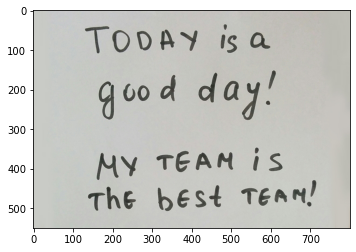

In [97]:
img = cv2.imread('text.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, c = img.shape

if w > 1000:
    
    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)
    
    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
plt.imshow(img);



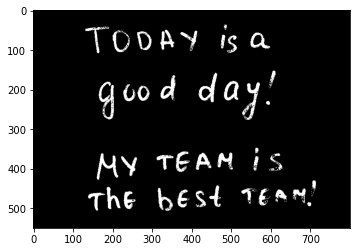

In [98]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img);


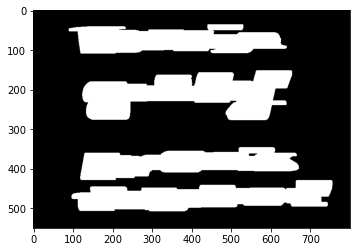

In [99]:
#dilation
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');


In [100]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

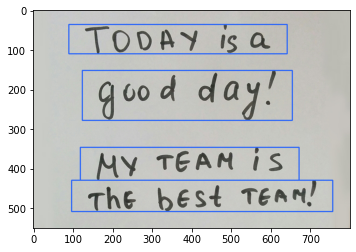

In [101]:
img2 = img.copy()

for ctr in sorted_contours_lines:
    
    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
    
plt.imshow(img2);


### Try word segmentation from same Github code

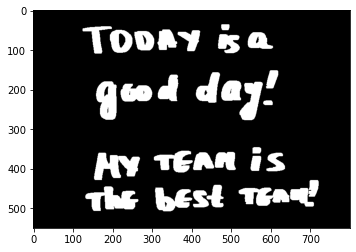

In [102]:
#dilation
kernel = np.ones((3,15), np.uint8)
dilated2 = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated2, cmap='gray');


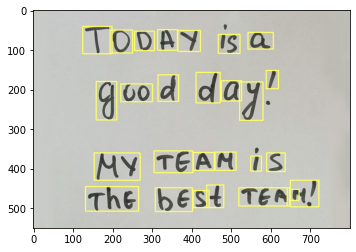

In [103]:
img3 = img.copy()
words_list = []

for line in sorted_contours_lines:
    
    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+w, x:x+w]
    
    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
    
    for word in sorted_contour_words:
        
        if cv2.contourArea(word) < 400:
            continue
        
        x2, y2, w2, h2 = cv2.boundingRect(word)
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255,100),2)
        
plt.imshow(img3);


### Try char segment using code from:
https://pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/

In [104]:
# import the necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
#import argparse
import imutils
import cv2
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to input image")
#ap.add_argument("-m", "--model", type=str, required=True,
#	help="path to trained handwriting recognition model")
#args = vars(ap.parse_args())

In [105]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread('text.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)
    # re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))
		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

In [106]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

In [107]:
boxes.sort(key=lambda tup:(tup[0]) )
count = 0
for box in boxes:
    [x,y,w,h] = box
    t = image[y:y+h,x:x+w,:]
    #cv2.imwrite(str(count)+".png",t)
    count += 1
print("number of char in image:", count)

number of char in image: 37


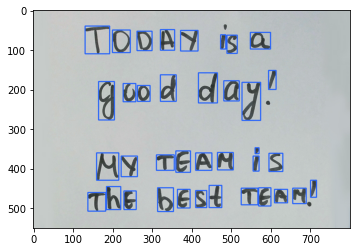

In [108]:
for box in boxes:
    
    x,y,w,h = box
    cv2.rectangle(image, (x,y), (x+w, y+h), (40, 100, 250), 2)
    
plt.imshow(image);

### Now try line by line segmentation

In [117]:
chars_by_line = []
boxes_by_line = []
original_image = cv2.imread('text.png')
count = 0
for line in sorted_contours_lines: 
    # load the input image from disk, convert it to grayscale, and blur
    # it to reduce noise
    x,y,w,h = cv2.boundingRect(line)
    image = original_image[y:y+h,x:x+w,:]

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # perform edge detection, find contours in the edge map, and sort the
    # resulting contours from left-to-right
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # initialize the list of contour bounding boxes and associated
    # characters that we'll be OCR'ing
    chars = []
    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # filter out bounding boxes, ensuring they are neither too small
        # nor too large
        if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
            # extract the character and threshold it to make the character
            # appear as *white* (foreground) on a *black* background, then
            # grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255,
                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the
            # width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
            else:
                thresh = imutils.resize(thresh, height=32)
        # re-grab the image dimensions (now that its been resized)
            # and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            # prepare the padded image for classification via our
            # handwriting OCR model
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")
    
    boxes.sort(key=lambda tup:(tup[0]) )
    for box in boxes:
        [x,y,w,h] = box
        t = image[y:y+h,x:x+w,:]
        #cv2.imwrite(str(count)+".png",t)
        count += 1
    print("number of char in image:", count)
    
    chars_by_line.append(chars)
    boxes_by_line.append(boxes)

number of char in image: 8
number of char in image: 17
number of char in image: 27
number of char in image: 39


chars should now be in the correct order